# Heatmap Visualization Tutorial: Failure Transition Matrices

## Learning Objectives

By completing this tutorial, you will be able to:
- ✅ Load and explore labeled failure trace data
- ✅ Extract failure transitions from trace records
- ✅ Build transition count matrices programmatically
- ✅ Configure seaborn heatmaps for effective visualization
- ✅ Interpret heatmap patterns to identify bottlenecks
- ✅ Export publication-quality heatmap visualizations
- ✅ Perform basic bottleneck analysis from matrices

## Prerequisites

- Completed [Transition Analysis Concepts](transition_analysis_concepts.md)
- Understanding of Python dictionaries and lists
- Familiarity with pandas and matplotlib

## Estimated Time

**Execution Time:** 15-20 minutes  
**Hands-on Exercises:** 10-15 minutes

## Setup and Imports

In [1]:
# Standard library
import json
from pathlib import Path
from collections import Counter
from typing import Dict, List, Tuple

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NOTE: No .env loading needed for this tutorial
# This notebook uses only local JSON data files (data/labeled_traces.json)
# and does not make any API calls. No API keys required.

# Configure visualization defaults
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 8)

print("\u2713 Imports successful")

✓ Imports successful


## 1. Load Labeled Trace Data

We'll load the pre-labeled failure traces from `data/labeled_traces.json`. Each trace contains:
- `trace_id`: Unique identifier
- `last_success_state`: Final state that succeeded
- `first_failure_state`: First state that failed
- `messages`: Full conversation history
- Additional metadata

In [4]:
# Define file paths
DATA_FILE = Path("data/labeled_traces.json")

# Load traces
if not DATA_FILE.exists():
    raise FileNotFoundError(
        f"Data file not found: {DATA_FILE}\n"
        "Make sure you're running this notebook from the homeworks/hw5/ directory."
    )

with open(DATA_FILE, 'r') as f:
    traces = json.load(f)

print(f"✓ Loaded {len(traces)} labeled failure traces")
print(f"✓ File: {DATA_FILE.resolve()}")

✓ Loaded 96 labeled failure traces
✓ File: /Users/rajnishkhatri/Documents/recipe-chatbot/homeworks/hw5/data/labeled_traces.json


### Explore a Sample Trace

Let's examine the structure of a single trace to understand what data we're working with.

In [6]:
# Display first trace (pretty-printed)
sample_trace = traces[0]

print("Sample Trace Structure:")
print("=" * 60)
print(f"Trace ID: {sample_trace['conversation_id']}")
print(f"Customer Persona: {sample_trace.get('customer_persona', 'N/A')}")
print(f"Last Success State: {sample_trace['last_success_state']}")
print(f"First Failure State: {sample_trace['first_failure_state']}")
print(f"Number of Messages: {len(sample_trace.get('messages', []))}")
print("\nFailure Transition:")
print(f"  {sample_trace['last_success_state']} → {sample_trace['first_failure_state']}")
print("=" * 60)

Sample Trace Structure:
Trace ID: 1373de99-f107-48da-b272-9e47c9b935dd
Customer Persona: N/A
Last Success State: ParseRequest
First Failure State: GetCustomerProfile
Number of Messages: 8

Failure Transition:
  ParseRequest → GetCustomerProfile


### Define Pipeline States

The recipe bot follows a 10-state pipeline. We'll define these states in order to structure our matrix.

In [7]:
# 10-state pipeline (in execution order)
PIPELINE_STATES = [
    "ParseRequest",        # LLM: Parse user query
    "PlanToolCalls",       # LLM: Decide which tools to use
    "GenCustomerArgs",     # LLM: Generate customer DB arguments
    "GetCustomerProfile",  # TOOL: Fetch customer profile
    "GenRecipeArgs",       # LLM: Generate recipe search arguments
    "GetRecipes",          # TOOL: Search recipe database
    "GenWebArgs",          # LLM: Generate web search arguments
    "GetWebInfo",          # TOOL: Perform web search
    "ComposeResponse",     # LLM: Draft final response
    "DeliverResponse",     # SYSTEM: Send response to user
]

# Create state → index mapping
STATE_INDEX = {state: idx for idx, state in enumerate(PIPELINE_STATES)}

print(f"✓ Pipeline has {len(PIPELINE_STATES)} states")
print("\nState Types:")
print("  LLM States:   ParseRequest, PlanToolCalls, GenCustomerArgs, GenRecipeArgs, GenWebArgs, ComposeResponse")
print("  Tool States:  GetCustomerProfile, GetRecipes, GetWebInfo")
print("  System State: DeliverResponse")

✓ Pipeline has 10 states

State Types:
  LLM States:   ParseRequest, PlanToolCalls, GenCustomerArgs, GenRecipeArgs, GenWebArgs, ComposeResponse
  Tool States:  GetCustomerProfile, GetRecipes, GetWebInfo
  System State: DeliverResponse


## 2. Extract Failure Transitions

A **failure transition** is the pair `(last_success_state, first_failure_state)` for each trace.

Let's extract all transitions and count their frequencies.

In [8]:
def extract_failure_transitions(traces: List[Dict]) -> List[Tuple[str, str]]:
    """Extract all (last_success, first_failure) pairs from traces.
    
    Args:
        traces: List of labeled trace dictionaries
        
    Returns:
        List of (from_state, to_state) tuples
    """
    transitions = []
    
    for trace in traces:
        from_state = trace.get('last_success_state')
        to_state = trace.get('first_failure_state')
        
        # Validate both states exist and are in our pipeline
        if from_state in STATE_INDEX and to_state in STATE_INDEX:
            transitions.append((from_state, to_state))
        else:
            print(f"⚠ Skipped invalid transition in {trace.get('trace_id')}: {from_state} → {to_state}")
    
    return transitions

# Extract transitions
failure_transitions = extract_failure_transitions(traces)

print(f"✓ Extracted {len(failure_transitions)} failure transitions")
print(f"✓ Coverage: {len(failure_transitions)}/{len(traces)} traces ({len(failure_transitions)/len(traces)*100:.1f}%)")

✓ Extracted 96 failure transitions
✓ Coverage: 96/96 traces (100.0%)


### Count Transition Frequencies

Use `Counter` to tally how many times each transition occurs.

In [9]:
# Count transition frequencies
transition_counts = Counter(failure_transitions)

print(f"Total unique transitions: {len(transition_counts)}")
print(f"\nTop 5 Most Common Failure Transitions:")
print("=" * 70)

for (from_state, to_state), count in transition_counts.most_common(5):
    percentage = count / len(failure_transitions) * 100
    print(f"{from_state:20} → {to_state:20} | Count: {count:3} ({percentage:5.1f}%)")

print("=" * 70)

Total unique transitions: 31

Top 5 Most Common Failure Transitions:
PlanToolCalls        → GenRecipeArgs        | Count:  10 ( 10.4%)
GetCustomerProfile   → GetRecipes           | Count:   9 (  9.4%)
GenCustomerArgs      → GetRecipes           | Count:   8 (  8.3%)
GenCustomerArgs      → GetCustomerProfile   | Count:   7 (  7.3%)
GetCustomerProfile   → GenRecipeArgs        | Count:   7 (  7.3%)


## 3. Build Transition Matrix

Convert the transition counts into a 10×10 matrix where:
- **Rows** = Last successful state
- **Columns** = First failing state
- **Cell value** = Number of times that transition occurred

In [11]:
def build_transition_matrix(traces: List[Dict], states: List[str]) -> np.ndarray:
    """Build transition count matrix from labeled traces.
    
    Args:
        traces: List of labeled trace dictionaries
        states: Ordered list of pipeline states
        
    Returns:
        n×n numpy array where n = len(states)
    """
    n = len(states)
    matrix = np.zeros((n, n), dtype=int)
    state_to_idx = {s: i for i, s in enumerate(states)}
    
    for trace in traces:
        from_state = trace.get('last_success_state')
        to_state = trace.get('first_failure_state')
        
        # Only count valid transitions
        if from_state in state_to_idx and to_state in state_to_idx:
            i = state_to_idx[from_state]
            j = state_to_idx[to_state]
            matrix[i, j] += 1
    
    return matrix

# Build matrix
transition_matrix = build_transition_matrix(traces, PIPELINE_STATES)

print(f"✓ Built {transition_matrix.shape[0]}×{transition_matrix.shape[1]} transition matrix")
print(f"✓ Total failures recorded: {transition_matrix.sum():.0f}")
print(f"✓ Non-zero cells: {np.count_nonzero(transition_matrix)}/{transition_matrix.size}")

✓ Built 10×10 transition matrix
✓ Total failures recorded: 96
✓ Non-zero cells: 31/100


### View Matrix as DataFrame

Convert to pandas DataFrame for easier inspection.

In [12]:
# Create labeled DataFrame
matrix_df = pd.DataFrame(
    transition_matrix,
    index=PIPELINE_STATES,
    columns=PIPELINE_STATES
)

print("Transition Matrix (rows=last success, columns=first failure):")
print("=" * 100)
display(matrix_df)
print("=" * 100)

Transition Matrix (rows=last success, columns=first failure):


,ParseRequest,PlanToolCalls,GenCustomerArgs,GetCustomerProfile,GenRecipeArgs,GetRecipes,GenWebArgs,GetWebInfo,ComposeResponse,DeliverResponse
ParseRequest,0,1,1,2,1,2,0,0,0,0
PlanToolCalls,0,0,6,4,10,6,2,2,0,1
GenCustomerArgs,0,0,0,7,2,8,1,1,1,0
GetCustomerProfile,0,0,0,0,7,9,0,0,0,0
GenRecipeArgs,0,0,0,0,0,7,2,0,1,1
GetRecipes,0,0,0,0,0,0,3,2,1,2
GenWebArgs,0,0,0,0,0,0,0,0,1,0
GetWebInfo,0,0,0,0,0,0,0,0,1,0
ComposeResponse,0,0,0,0,0,0,0,0,0,1
DeliverResponse,0,0,0,0,0,0,0,0,0,0


## 4. Visualize with Seaborn Heatmap

Create an annotated heatmap to visualize failure patterns.

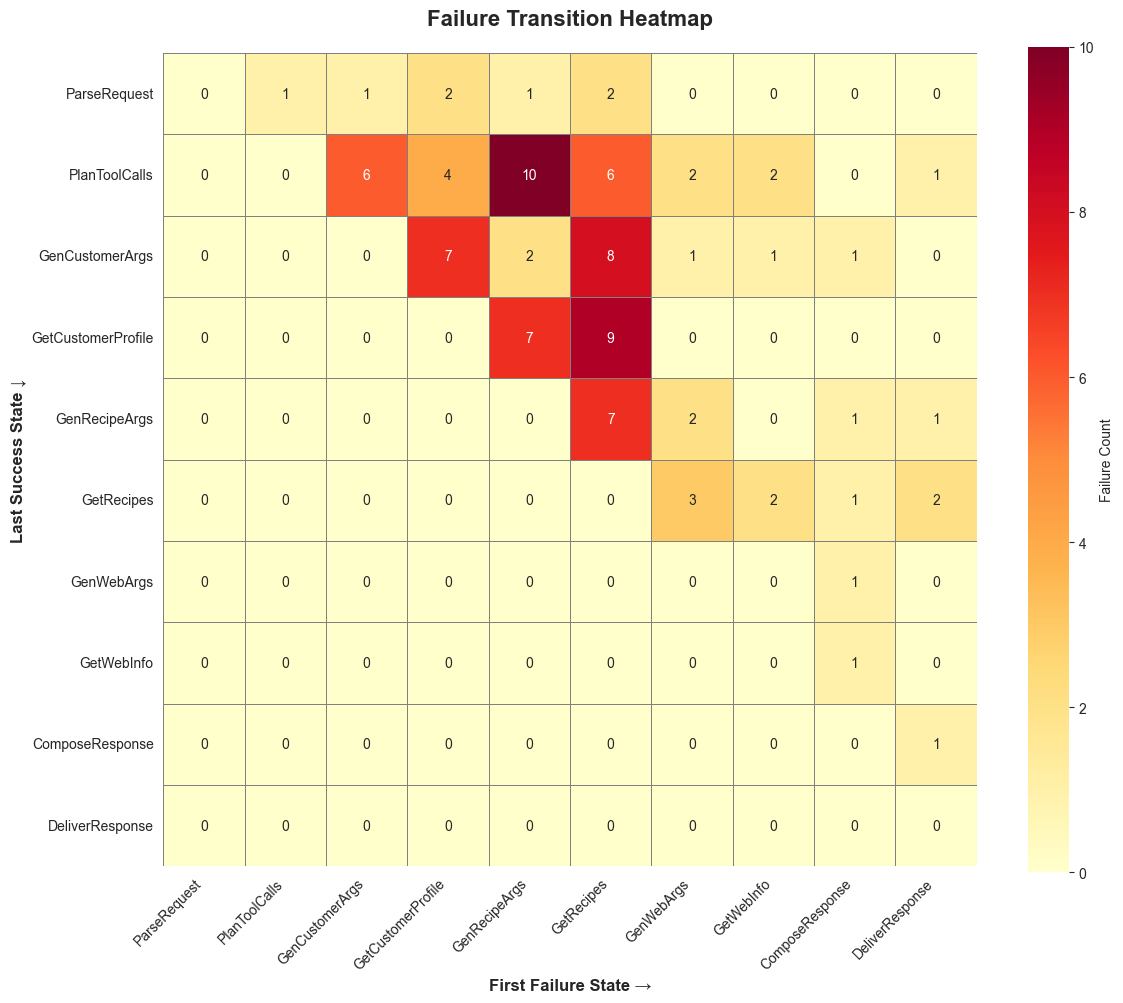

In [26]:
def plot_transition_heatmap(
    matrix: np.ndarray,
    states: List[str],
    title: str = "Failure Transition Heatmap",
    cmap: str = "YlOrRd",
    figsize: Tuple[int, int] = (12, 10),
    fmt: str = "d",
    cbar_label: str = "Failure Count"
) -> None:
    """Plot annotated heatmap of transition matrix.
    
    Args:
        matrix: Transition count matrix
        states: State labels for axes
        title: Plot title
        cmap: Seaborn color palette
        figsize: Figure dimensions (width, height)
        fmt: Format string for annotations (e.g., "d" for integers, ".1f" for floats)
        cbar_label: Label for the colorbar
    """
    plt.figure(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(
        matrix,
        annot=True,           # Show count values in cells
        fmt=fmt,              # Format string (default: "d" for integers)
        cmap=cmap,            # Color scheme (yellow → red)
        xticklabels=states,
        yticklabels=states,
        cbar_kws={"label": cbar_label},
        square=True,          # Square cells
        linewidths=0.5,       # Grid lines
        linecolor='gray'
    )
    
    # Formatting
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("First Failure State →", fontsize=12, fontweight='bold')
    plt.ylabel("Last Success State ↓", fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Generate heatmap
plot_transition_heatmap(transition_matrix, PIPELINE_STATES)

### Interpret the Heatmap

**Reading the Heatmap:**
- **Darker cells** = Higher failure counts
- **Row** = Where the system last succeeded
- **Column** = Where the system first failed
- **Diagonal** = State succeeded, then immediately failed on retry (rare)
- **Off-diagonal** = Failure in next sequential state (common)

**Common Patterns:**
1. **Single dark cell** = Clustered bottleneck (most failures at one transition)
2. **Dark column** = Specific state fails from multiple predecessors
3. **Dark row** = After one state, failures scatter across next states
4. **Distributed darkness** = No clear bottleneck (diverse failures)

## 5. Bottleneck Analysis

Perform quantitative analysis to identify system bottlenecks.

### Which States Fail Most Often? (Column Sums)

In [27]:
# Sum failures by column (how often each state fails)
column_sums = transition_matrix.sum(axis=0)

# Create summary DataFrame
failure_by_state = pd.DataFrame({
    'State': PIPELINE_STATES,
    'Total Failures': column_sums,
    'Percentage': column_sums / column_sums.sum() * 100
}).sort_values('Total Failures', ascending=False)

print("States Ranked by Failure Frequency (Column Sums):")
print("=" * 60)
display(failure_by_state)
print("=" * 60)

# Identify primary bottleneck
primary_bottleneck = failure_by_state.iloc[0]
print(f"\n🔴 PRIMARY BOTTLENECK: {primary_bottleneck['State']}")
print(f"   Fails {primary_bottleneck['Total Failures']:.0f} times ({primary_bottleneck['Percentage']:.1f}% of all failures)")

States Ranked by Failure Frequency (Column Sums):


,State,Total Failures,Percentage
5,GetRecipes,32,33.333333
4,GenRecipeArgs,20,20.833333
3,GetCustomerProfile,13,13.541667
6,GenWebArgs,8,8.333333
2,GenCustomerArgs,7,7.291667
7,GetWebInfo,5,5.208333
8,ComposeResponse,5,5.208333
9,DeliverResponse,5,5.208333
1,PlanToolCalls,1,1.041667
0,ParseRequest,0,0.000000



🔴 PRIMARY BOTTLENECK: GetRecipes
   Fails 32 times (33.3% of all failures)


### After Which States Do Failures Occur? (Row Sums)

In [15]:
# Sum failures by row (after which state do failures happen)
row_sums = transition_matrix.sum(axis=1)

# Create summary DataFrame
failures_after_state = pd.DataFrame({
    'State': PIPELINE_STATES,
    'Failures After This State': row_sums,
    'Percentage': row_sums / row_sums.sum() * 100
}).sort_values('Failures After This State', ascending=False)

print("States with Most Downstream Failures (Row Sums):")
print("=" * 70)
display(failures_after_state)
print("=" * 70)

# Identify upstream cause
upstream_issue = failures_after_state.iloc[0]
print(f"\n⚠️  UPSTREAM RISK: {upstream_issue['State']}")
print(f"   Followed by {upstream_issue['Failures After This State']:.0f} failures ({upstream_issue['Percentage']:.1f}% of total)")

States with Most Downstream Failures (Row Sums):


,State,Failures After This State,Percentage
1,PlanToolCalls,31,32.291667
2,GenCustomerArgs,20,20.833333
3,GetCustomerProfile,16,16.666667
4,GenRecipeArgs,11,11.458333
5,GetRecipes,8,8.333333
0,ParseRequest,7,7.291667
6,GenWebArgs,1,1.041667
7,GetWebInfo,1,1.041667
8,ComposeResponse,1,1.041667
9,DeliverResponse,0,0.000000



⚠️  UPSTREAM RISK: PlanToolCalls
   Followed by 31 failures (32.3% of total)


### Most Common Single Transition

In [16]:
# Find cell with maximum value
max_value = transition_matrix.max()
max_indices = np.argwhere(transition_matrix == max_value)

print(f"Most Frequent Failure Transition(s):")
print("=" * 70)

for i, j in max_indices:
    from_state = PIPELINE_STATES[i]
    to_state = PIPELINE_STATES[j]
    percentage = max_value / transition_matrix.sum() * 100
    
    print(f"  {from_state} → {to_state}")
    print(f"  Count: {max_value} occurrences ({percentage:.1f}% of all failures)")
    print()

print("=" * 70)

Most Frequent Failure Transition(s):
  PlanToolCalls → GenRecipeArgs
  Count: 10 occurrences (10.4% of all failures)



## 6. Export Heatmap

Save publication-quality PNG for reports.

In [17]:
def save_heatmap(
    matrix: np.ndarray,
    states: List[str],
    output_path: Path,
    dpi: int = 300
) -> None:
    """Save heatmap to PNG file.
    
    Args:
        matrix: Transition count matrix
        states: State labels
        output_path: Output file path
        dpi: Resolution (300 for publication quality)
    """
    # Ensure output directory exists
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Create figure
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="YlOrRd",
        xticklabels=states,
        yticklabels=states,
        cbar_kws={"label": "Failure Count"},
        square=True,
        linewidths=0.5,
        linecolor='gray'
    )
    
    plt.title("Failure Transition Heatmap", fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("First Failure State →", fontsize=12, fontweight='bold')
    plt.ylabel("Last Success State ↓", fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save
    plt.savefig(output_path, dpi=dpi, bbox_inches='tight')
    plt.close()
    
    print(f"✓ Heatmap saved to: {output_path.resolve()}")
    print(f"  Resolution: {dpi} DPI")
    print(f"  File size: {output_path.stat().st_size / 1024:.1f} KB")

# Save to results/
OUTPUT_PATH = Path("results/failure_transition_heatmap.png")
save_heatmap(transition_matrix, PIPELINE_STATES, OUTPUT_PATH)

✓ Heatmap saved to: /Users/rajnishkhatri/Documents/recipe-chatbot/homeworks/hw5/results/failure_transition_heatmap.png
  Resolution: 300 DPI
  File size: 303.7 KB


## 7. Exercises and Next Steps

### Exercise 1: Filter by Customer Persona

Build separate transition matrices for different customer personas (e.g., `vegan_family`, `gluten_free_athlete`) to see if failure patterns differ.

Checking for customer_persona field in traces...
⚠️  customer_persona field NOT found in traces
   Available fields: ['conversation_id', 'messages', 'last_success_state', 'first_failure_state']

⚠️  Cannot check for personas '['vegan_family', 'gluten_free_athlete']' - customer_persona field doesn't exist
   These personas may need to be inferred from message content or added to the data

Found 1 persona groups:
  Unspecified: 96 traces

Persona: Unspecified (96 traces, 96 failures)
🔴 Primary Bottleneck: GetRecipes (32 failures, 33.3%)


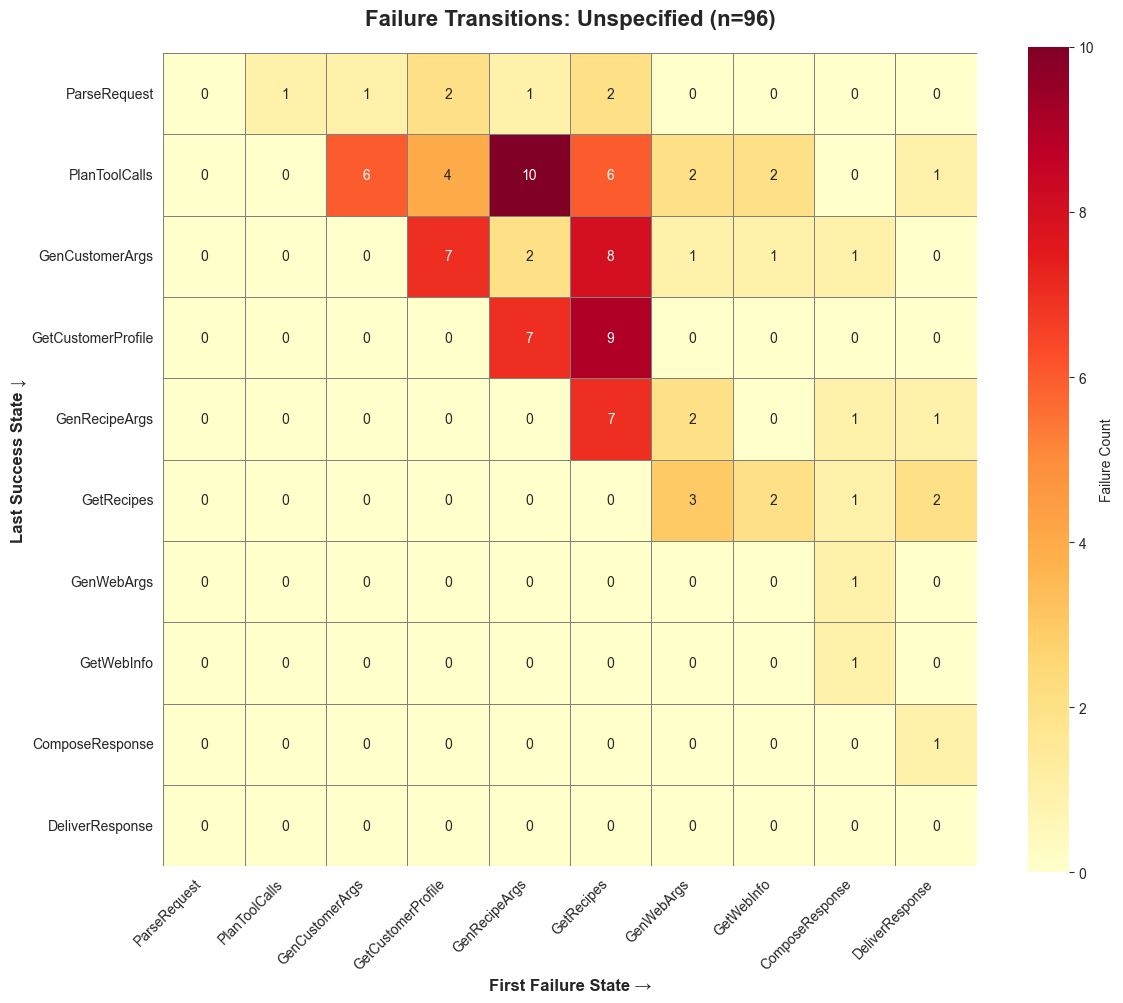

In [20]:
# Group traces by customer_persona and build separate matrices
# Handle traces without persona by grouping them as "Unspecified"

# First, check if customer_persona field exists in the data
sample_trace = traces[0]
has_persona_field = 'customer_persona' in sample_trace

print("Checking for customer_persona field in traces...")
print("=" * 60)
if has_persona_field:
    print("✓ customer_persona field found in traces")
else:
    print("⚠️  customer_persona field NOT found in traces")
    print("   Available fields:", list(sample_trace.keys()))
print("=" * 60)

# Check specifically for requested personas
target_personas = ["vegan_family", "gluten_free_athlete"]
persona_counts = {}

if has_persona_field:
    for trace in traces:
        persona = trace.get('customer_persona')
        if persona in target_personas:
            persona_counts[persona] = persona_counts.get(persona, 0) + 1
    
    print(f"\nChecking for specific personas: {target_personas}")
    print("=" * 60)
    for target_persona in target_personas:
        count = persona_counts.get(target_persona, 0)
        if count > 0:
            print(f"✓ Found '{target_persona}': {count} traces")
        else:
            print(f"✗ '{target_persona}': NOT FOUND in data")
    print("=" * 60)
else:
    print(f"\n⚠️  Cannot check for personas '{target_personas}' - customer_persona field doesn't exist")
    print("   These personas may need to be inferred from message content or added to the data")

# Get all unique personas (including None/empty values)
personas_dict = {}
for trace in traces:
    persona = trace.get('customer_persona', None)
    # Normalize None/empty personas to "Unspecified"
    persona_key = persona if persona and persona.strip() else "Unspecified"
    
    if persona_key not in personas_dict:
        personas_dict[persona_key] = []
    personas_dict[persona_key].append(trace)

print(f"\n{'='*60}")
print(f"Found {len(personas_dict)} persona groups:")
print("=" * 60)
for persona, persona_traces in sorted(personas_dict.items()):
    print(f"  {persona}: {len(persona_traces)} traces")
print("=" * 60)

# Build and visualize matrices for each persona
for persona, persona_traces in sorted(personas_dict.items()):
    persona_matrix = build_transition_matrix(persona_traces, PIPELINE_STATES)
    total_failures = persona_matrix.sum()
    
    if total_failures > 0:
        print(f"\n{'='*60}")
        print(f"Persona: {persona} ({len(persona_traces)} traces, {total_failures} failures)")
        print(f"{'='*60}")
        
        # Identify bottleneck for this persona
        column_sums = persona_matrix.sum(axis=0)
        if column_sums.max() > 0:
            max_failures_idx = column_sums.argmax()
            bottleneck_state = PIPELINE_STATES[max_failures_idx]
            bottleneck_count = column_sums[max_failures_idx]
            print(f"🔴 Primary Bottleneck: {bottleneck_state} ({bottleneck_count} failures, {bottleneck_count/total_failures*100:.1f}%)")
        
        # Plot heatmap
        plot_transition_heatmap(
            persona_matrix, 
            PIPELINE_STATES, 
            title=f"Failure Transitions: {persona} (n={len(persona_traces)})"
        )
    else:
        print(f"\n⚠️  Skipping {persona}: No failures recorded in this group")

### Exercise 2: Investigate High-Frequency Transition

Read all traces with the most common failure transition to identify patterns.

In [28]:
# Filter traces by (last_success_state, first_failure_state) pair
# Examine their user queries, customer personas, or other metadata

# Use the most common failure transition from earlier analysis
target_from = "PlanToolCalls"
target_to = "GenRecipeArgs"

# Filter traces matching this transition
matching_traces = [
    t for t in traces 
    if t['last_success_state'] == target_from and t['first_failure_state'] == target_to
]

print(f"Found {len(matching_traces)} traces with {target_from} → {target_to}")
print("=" * 70)

# Extract and examine patterns
print("\n📊 Summary Statistics:")
print("=" * 70)
print(f"  Total matching traces: {len(matching_traces)}")
print(f"  Percentage of all failures: {len(matching_traces)/len(traces)*100:.1f}%")

# Extract user queries from messages
user_queries = []
for trace in matching_traces:
    # Get first user message (usually the initial query)
    for msg in trace.get('messages', []):
        if msg.get('role') == 'user':
            user_queries.append({
                'conversation_id': trace['conversation_id'],
                'query': msg.get('content', ''),
                'persona': trace.get('customer_persona', 'N/A')
            })
            break  # Only get first user message

print(f"\n  User queries extracted: {len(user_queries)}")

# Display detailed information for all matching traces
print(f"\n{'='*70}")
print(f"Detailed Trace Analysis: {target_from} → {target_to}")
print(f"{'='*70}")

for idx, trace in enumerate(matching_traces, 1):
    print(f"\n[{idx}/{len(matching_traces)}] Trace ID: {trace['conversation_id']}")
    print("-" * 70)
    
    # Get user query
    user_query = "N/A"
    for msg in trace.get('messages', []):
        if msg.get('role') == 'user':
            user_query = msg.get('content', 'N/A')
            break
    
    print(f"  User Query: {user_query[:80]}{'...' if len(user_query) > 80 else ''}")
    print(f"  Customer Persona: {trace.get('customer_persona', 'N/A')}")
    print(f"  Last Success: {trace['last_success_state']}")
    print(f"  First Failure: {trace['first_failure_state']}")
    print(f"  Total Messages: {len(trace.get('messages', []))}")
    
    # Show failure context (messages around the failure)
    messages = trace.get('messages', [])
    print(f"\n  Failure Context (last 3 messages before failure):")
    for msg in messages[-3:]:
        role = msg.get('role', 'unknown')
        content = msg.get('content', '')[:100]
        print(f"    [{role}]: {content}{'...' if len(msg.get('content', '')) > 100 else ''}")

print(f"\n{'='*70}")
print("\n🔍 Pattern Analysis:")
print("=" * 70)

# Analyze query patterns
if user_queries:
    # Check for common keywords
    all_text = ' '.join([q['query'].lower() for q in user_queries])
    common_words = ['breakfast', 'dinner', 'lunch', 'recipe', 'healthy', 'quick', 'easy', 
                    'vegetarian', 'vegan', 'gluten', 'protein', 'low', 'sugar', 'sodium']
    
    print("\n  Common keywords in queries:")
    for word in common_words:
        count = all_text.count(word)
        if count > 0:
            print(f"    '{word}': appears in {count} queries")
    
    # Show unique query patterns
    print(f"\n  Unique query patterns:")
    print(f"    Total unique queries: {len(set(q['query'] for q in user_queries))}")
    
    if len(matching_traces) > 0:
        print(f"\n  Average message count: {sum(len(t.get('messages', [])) for t in matching_traces) / len(matching_traces):.1f}")

print("=" * 70)

Found 10 traces with PlanToolCalls → GenRecipeArgs

📊 Summary Statistics:
  Total matching traces: 10
  Percentage of all failures: 10.4%

  User queries extracted: 10

Detailed Trace Analysis: PlanToolCalls → GenRecipeArgs

[1/10] Trace ID: c5d52ab6-5c06-4ca3-adb0-52fe6dc26f8b
----------------------------------------------------------------------
  User Query: I need a gluten-free dinner idea for four.
  Customer Persona: N/A
  Last Success: PlanToolCalls
  First Failure: GenRecipeArgs
  Total Messages: 8

  Failure Context (last 3 messages before failure):
    [assistant]: Could you tell me if there are any other dietary restrictions or preferred cuisines?
    [user]: No other restrictions. Something quick would be great!
    [assistant]: Thanks! Once I have a suitable recipe, I'll share a quick gluten-free dinner idea for you.

[2/10] Trace ID: d7e5416f-9e5a-4147-bc30-8e93aca741e4
----------------------------------------------------------------------
  User Query: What vegetarian hi

### Exercise 3: Normalized Heatmap (Percentages)

Create a heatmap showing percentages instead of raw counts.

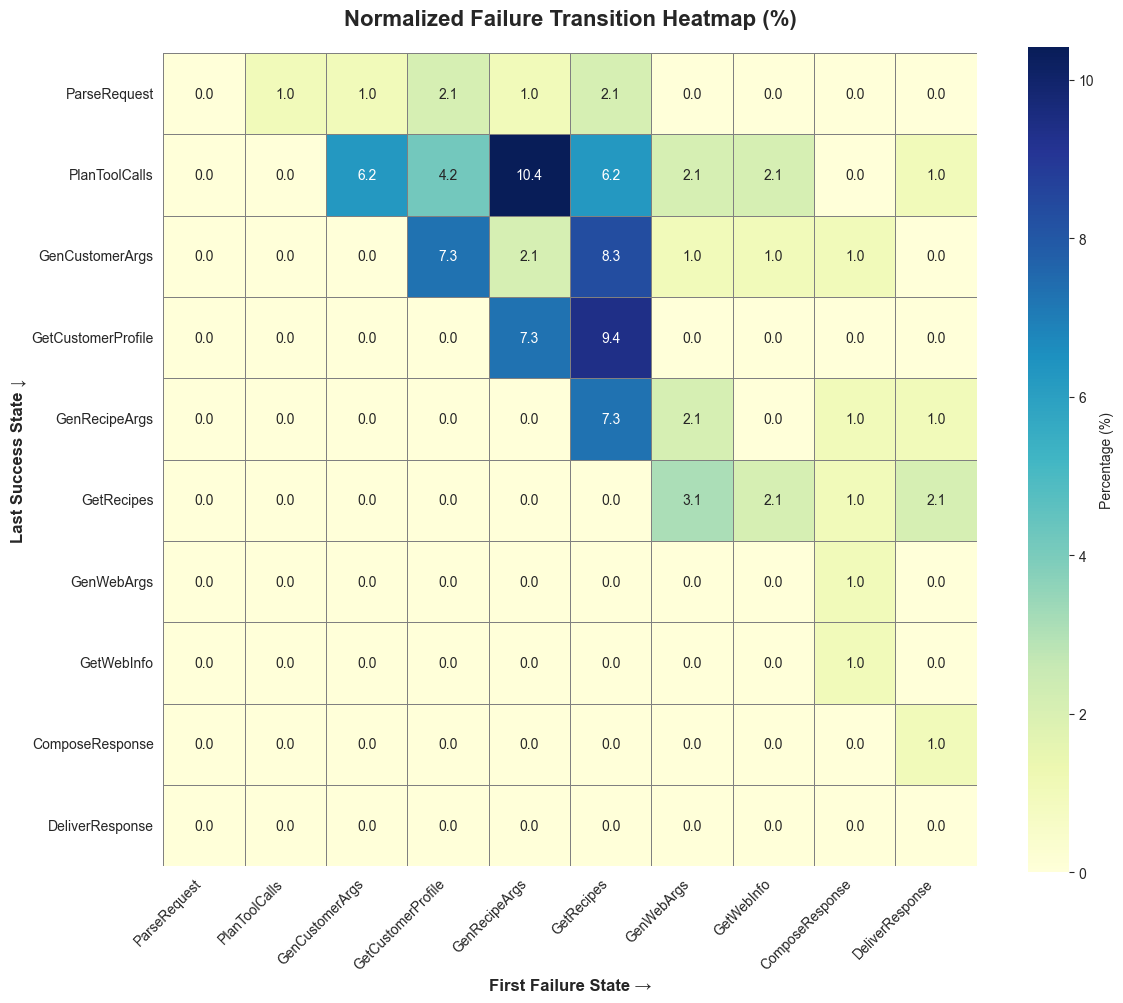

In [29]:
# Normalize matrix to percentages
normalized_matrix = (transition_matrix / transition_matrix.sum()) * 100

# Plot with fmt=".1f" to show 1 decimal place and update colorbar label
plot_transition_heatmap(
    normalized_matrix, 
    PIPELINE_STATES, 
    title="Normalized Failure Transition Heatmap (%)",
    cmap="YlGnBu",
    fmt=".1f",  # Format as float with 1 decimal place
    cbar_label="Percentage (%)"  # Update colorbar label for percentages
)

## Summary and Key Takeaways

In this tutorial, you learned to:

1. **Load and explore labeled failure traces** from JSON
2. **Extract failure transitions** as `(last_success, first_failure)` pairs
3. **Build transition count matrices** programmatically
4. **Visualize patterns with seaborn heatmaps** using effective color schemes
5. **Identify bottlenecks** through column/row sum analysis
6. **Export publication-quality visualizations** at 300 DPI

### Next Steps

- **Read traces** with high-frequency transitions to understand root causes
- **Propose fixes** for identified bottlenecks (better prompts, tool improvements)
- **Re-run analysis** after implementing fixes to verify improvement
- **Explore** [Transition Analysis Concepts](transition_analysis_concepts.md) for deeper methodology

### Related Tutorials

- [Transition Analysis Concepts](transition_analysis_concepts.md) - Theory and methodology
- [Transition Matrix Diagram](diagrams/transition_matrix_concept.mmd) - Visual pipeline reference
- [HW5 Tutorial Index](TUTORIAL_INDEX.md) - Complete learning path

---

**Tutorial Status:** ✅ Complete  
**Last Updated:** 2025-10-30  
**Maintainer:** AI Evaluation Course Team